# Frenet Optimal Planning

In [11]:
"""
cubic spline planner

Author: Atsushi Sakai

"""
import math
import numpy as np
import bisect
import matplotlib.pyplot as plt
import copy
import cubic_spline_planner


class Spline:
    """
    Cubic Spline class
    """

    def __init__(self, x, y):
        self.b, self.c, self.d, self.w = [], [], [], []

        self.x = x
        self.y = y

        self.nx = len(x)  # dimension of x
        h = np.diff(x)

        # calc coefficient c
        self.a = [iy for iy in y]

        # calc coefficient c
        A = self.__calc_A(h)
        B = self.__calc_B(h)
        self.c = np.linalg.solve(A, B)
        #  print(self.c1)

        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))
            tb = (self.a[i + 1] - self.a[i]) / h[i] - h[i] * \
                (self.c[i + 1] + 2.0 * self.c[i]) / 3.0
            self.b.append(tb)

    def calc(self, t):
        """
        Calc position

        if t is outside of the input x, return None

        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0 + self.d[i] * dx ** 3.0

        return result

    def calcd(self, t):
        """
        Calc first derivative

        if t is outside of the input x, return None
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.b[i] + 2.0 * self.c[i] * dx + 3.0 * self.d[i] * dx ** 2.0
        return result

    def calcdd(self, t):
        """
        Calc second derivative
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = 2.0 * self.c[i] + 6.0 * self.d[i] * dx
        return result

    def __search_index(self, x):
        """
        search data segment index
        """
        return bisect.bisect(self.x, x) - 1

    def __calc_A(self, h):
        """
        calc matrix A for spline coefficient c
        """
        A = np.zeros((self.nx, self.nx))
        A[0, 0] = 1.0
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[self.nx - 1, self.nx - 2] = 0.0
        A[self.nx - 1, self.nx - 1] = 1.0
        #  print(A)
        return A

    def __calc_B(self, h):
        """
        calc matrix B for spline coefficient c
        """
        B = np.zeros(self.nx)
        for i in range(self.nx - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / \
                h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
        #  print(B)
        return B

In [12]:
class Spline2D:
    """
    2D Cubic Spline class

    """

    def __init__(self, x, y):
        self.s = self.__calc_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def __calc_s(self, x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        self.ds = [math.sqrt(idx ** 2 + idy ** 2)
                   for (idx, idy) in zip(dx, dy)]
        s = [0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        """
        calc position
        """
        x = self.sx.calc(s)
        y = self.sy.calc(s)

        return x, y

    def calc_curvature(self, s):
        """
        calc curvature
        """
        dx = self.sx.calcd(s)
        ddx = self.sx.calcdd(s)
        dy = self.sy.calcd(s)
        ddy = self.sy.calcdd(s)
        k = (ddy * dx - ddx * dy) / (dx ** 2 + dy ** 2)
        return k

    def calc_yaw(self, s):
        """
        calc yaw
        """
        dx = self.sx.calcd(s)
        dy = self.sy.calcd(s)
        yaw = math.atan2(dy, dx)
        return yaw


def calc_spline_course(x, y, ds=0.1):
    sp = Spline2D(x, y)
    s = list(np.arange(0, sp.s[-1], ds))

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, s


In [13]:
class quintic_polynomial:

    def __init__(self, xs, vxs, axs, xe, vxe, axe, T):

        # calc coefficient of quintic polynomial
        self.xs = xs
        self.vxs = vxs
        self.axs = axs
        self.xe = xe
        self.vxe = vxe
        self.axe = axe

        self.a0 = xs
        self.a1 = vxs
        self.a2 = axs / 2.0

        A = np.array([[T**3, T**4, T**5],
                      [3 * T ** 2, 4 * T ** 3, 5 * T ** 4],
                      [6 * T, 12 * T ** 2, 20 * T ** 3]])
        b = np.array([xe - self.a0 - self.a1 * T - self.a2 * T**2,
                      vxe - self.a1 - 2 * self.a2 * T,
                      axe - 2 * self.a2])
        x = np.linalg.solve(A, b)

        self.a3 = x[0]
        self.a4 = x[1]
        self.a5 = x[2]

    def calc_point(self, t):
        xt = self.a0 + self.a1 * t + self.a2 * t**2 + \
            self.a3 * t**3 + self.a4 * t**4 + self.a5 * t**5

        return xt

    def calc_first_derivative(self, t):
        xt = self.a1 + 2 * self.a2 * t + \
            3 * self.a3 * t**2 + 4 * self.a4 * t**3 + 5 * self.a5 * t**4

        return xt

    def calc_second_derivative(self, t):
        xt = 2 * self.a2 + 6 * self.a3 * t + 12 * self.a4 * t**2 + 20 * self.a5 * t**3

        return xt

    def calc_third_derivative(self, t):
        xt = 6 * self.a3 + 24 * self.a4 * t + 60 * self.a5 * t**2

        return xt


In [14]:
class quartic_polynomial:

    def __init__(self, xs, vxs, axs, vxe, axe, T):

        # calc coefficient of quintic polynomial
        self.xs = xs
        self.vxs = vxs
        self.axs = axs
        self.vxe = vxe
        self.axe = axe

        self.a0 = xs
        self.a1 = vxs
        self.a2 = axs / 2.0

        A = np.array([[3 * T ** 2, 4 * T ** 3],
                      [6 * T, 12 * T ** 2]])
        b = np.array([vxe - self.a1 - 2 * self.a2 * T,
                      axe - 2 * self.a2])
        x = np.linalg.solve(A, b)

        self.a3 = x[0]
        self.a4 = x[1]

    def calc_point(self, t):
        xt = self.a0 + self.a1 * t + self.a2 * t**2 + \
            self.a3 * t**3 + self.a4 * t**4

        return xt

    def calc_first_derivative(self, t):
        xt = self.a1 + 2 * self.a2 * t + \
            3 * self.a3 * t**2 + 4 * self.a4 * t**3

        return xt

    def calc_second_derivative(self, t):
        xt = 2 * self.a2 + 6 * self.a3 * t + 12 * self.a4 * t**2

        return xt

    def calc_third_derivative(self, t):
        xt = 6 * self.a3 + 24 * self.a4 * t

        return xt

In [15]:
class Frenet_path:

    def __init__(self):
        self.t = []
        self.d = []
        self.d_d = []
        self.d_dd = []
        self.d_ddd = []
        self.s = []
        self.s_d = []
        self.s_dd = []
        self.s_ddd = []
        self.cd = 0.0
        self.cv = 0.0
        self.cf = 0.0

        self.x = []
        self.y = []
        self.yaw = []
        self.ds = []
        self.c = []


def calc_frenet_paths(c_speed, c_d, c_d_d, c_d_dd, s0):

    frenet_paths = []

    # generate path to each offset goal
    for di in np.arange(-MAX_ROAD_WIDTH, MAX_ROAD_WIDTH, D_ROAD_W):

        # Lateral motion planning
        for Ti in np.arange(MINT, MAXT, DT):
            fp = Frenet_path()

            lat_qp = quintic_polynomial(c_d, c_d_d, c_d_dd, di, 0.0, 0.0, Ti)

            fp.t = [t for t in np.arange(0.0, Ti, DT)]
            fp.d = [lat_qp.calc_point(t) for t in fp.t]
            fp.d_d = [lat_qp.calc_first_derivative(t) for t in fp.t]
            fp.d_dd = [lat_qp.calc_second_derivative(t) for t in fp.t]
            fp.d_ddd = [lat_qp.calc_third_derivative(t) for t in fp.t]

            # Loongitudinal motion planning (Velocity keeping)
            for tv in np.arange(TARGET_SPEED - D_T_S * N_S_SAMPLE, TARGET_SPEED + D_T_S * N_S_SAMPLE, D_T_S):
                tfp = copy.deepcopy(fp)
                lon_qp = quartic_polynomial(s0, c_speed, 0.0, tv, 0.0, Ti)

                tfp.s = [lon_qp.calc_point(t) for t in fp.t]
                tfp.s_d = [lon_qp.calc_first_derivative(t) for t in fp.t]
                tfp.s_dd = [lon_qp.calc_second_derivative(t) for t in fp.t]
                tfp.s_ddd = [lon_qp.calc_third_derivative(t) for t in fp.t]

                Jp = sum(np.power(tfp.d_ddd, 2))  # square of jerk
                Js = sum(np.power(tfp.s_ddd, 2))  # square of jerk

                # square of diff from target speed
                ds = (TARGET_SPEED - tfp.s_d[-1])**2

                tfp.cd = KJ * Jp + KT * Ti + KD * tfp.d[-1]**2
                tfp.cv = KJ * Js + KT * Ti + KD * ds
                tfp.cf = KLAT * tfp.cd + KLON * tfp.cv

                frenet_paths.append(tfp)

    return frenet_paths


def calc_global_paths(fplist, csp):

    for fp in fplist:

        # calc global positions
        for i in range(len(fp.s)):
            ix, iy = csp.calc_position(fp.s[i])
            if ix is None:
                break
            iyaw = csp.calc_yaw(fp.s[i])
            di = fp.d[i]
            fx = ix + di * math.cos(iyaw + math.pi / 2.0)
            fy = iy + di * math.sin(iyaw + math.pi / 2.0)
            fp.x.append(fx)
            fp.y.append(fy)

        # calc yaw and ds
        for i in range(len(fp.x) - 1):
            dx = fp.x[i + 1] - fp.x[i]
            dy = fp.y[i + 1] - fp.y[i]
            fp.yaw.append(math.atan2(dy, dx))
            fp.ds.append(math.sqrt(dx**2 + dy**2))

        fp.yaw.append(fp.yaw[-1])
        fp.ds.append(fp.ds[-1])

        # calc curvature
        for i in range(len(fp.yaw) - 1):
            fp.c.append((fp.yaw[i + 1] - fp.yaw[i]) / fp.ds[i])

    return fplist


def check_collision(fp, ob):

    for i in range(len(ob[:, 0])):
        d = [((ix - ob[i, 0])**2 + (iy - ob[i, 1])**2)
             for (ix, iy) in zip(fp.x, fp.y)]

        collision = any([di <= ROBOT_RADIUS**2 for di in d])

        if collision:
            return False

    return True


def check_paths(fplist, ob):

    okind = []
    for i, _ in enumerate(fplist):
        if any([v > MAX_SPEED for v in fplist[i].s_d]):  # Max speed check
            continue
        elif any([abs(a) > MAX_ACCEL for a in fplist[i].s_dd]):  # Max accel check
            continue
        elif any([abs(c) > MAX_CURVATURE for c in fplist[i].c]):  # Max curvature check
            continue
        elif not check_collision(fplist[i], ob):
            continue

        okind.append(i)

    return [fplist[i] for i in okind]


def frenet_optimal_planning(csp, s0, c_speed, c_d, c_d_d, c_d_dd, ob):

    fplist = calc_frenet_paths(c_speed, c_d, c_d_d, c_d_dd, s0)
    fplist = calc_global_paths(fplist, csp)
    fplist = check_paths(fplist, ob)

    # find minimum cost path
    mincost = float("inf")
    bestpath = None
    for fp in fplist:
        if mincost >= fp.cf:
            mincost = fp.cf
            bestpath = fp

    return bestpath


def generate_target_course(x, y):
    csp = cubic_spline_planner.Spline2D(x, y)
    s = np.arange(0, csp.s[-1], 0.1)

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = csp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(csp.calc_yaw(i_s))
        rk.append(csp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, csp

In [16]:
"""

Frenet optimal trajectory generator

author: Atsushi Sakai (@Atsushi_twi)

Ref:

- [Optimal Trajectory Generation for Dynamic Street Scenarios in a Frenet Frame](https://www.researchgate.net/profile/Moritz_Werling/publication/224156269_Optimal_Trajectory_Generation_for_Dynamic_Street_Scenarios_in_a_Frenet_Frame/links/54f749df0cf210398e9277af.pdf)

- [Optimal trajectory generation for dynamic street scenarios in a Frenet Frame](https://www.youtube.com/watch?v=Cj6tAQe7UCY)

"""

SIM_LOOP = 500

# Parameter
MAX_SPEED = 50.0 / 3.6  # maximum speed [m/s]
MAX_ACCEL = 2.0  # maximum acceleration [m/ss]
MAX_CURVATURE = 1.0  # maximum curvature [1/m]
MAX_ROAD_WIDTH = 7.0  # maximum road width [m]
D_ROAD_W = 1.0  # road width sampling length [m]
DT = 0.2  # time tick [s]
MAXT = 5.0  # max prediction time [m]
MINT = 4.0  # min prediction time [m]
TARGET_SPEED = 30.0 / 3.6  # target speed [m/s]
D_T_S = 5.0 / 3.6  # target speed sampling length [m/s]
N_S_SAMPLE = 1  # sampling number of target speed
ROBOT_RADIUS = 2.0  # robot radius [m]

# cost weights
KJ = 0.1
KT = 0.1
KD = 1.0
KLAT = 1.0
KLON = 1.0

show_animation = True


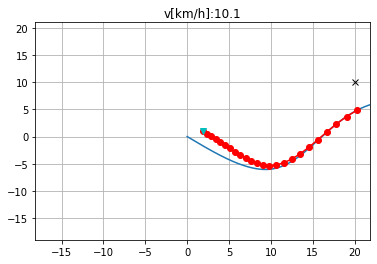

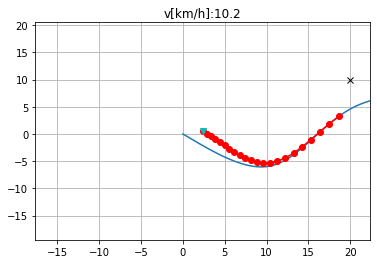

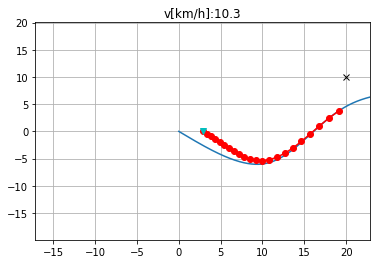

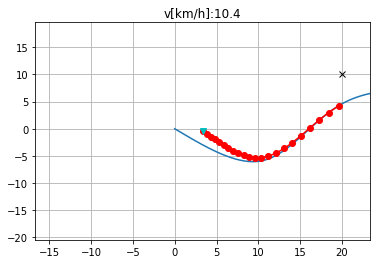

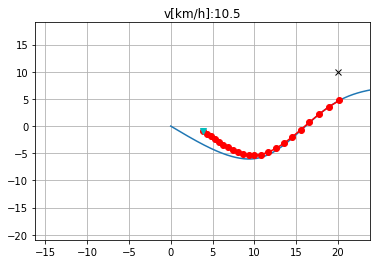

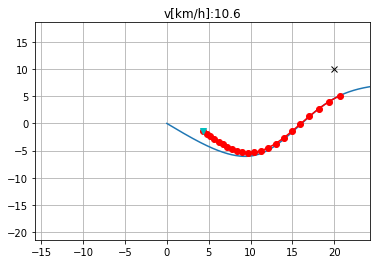

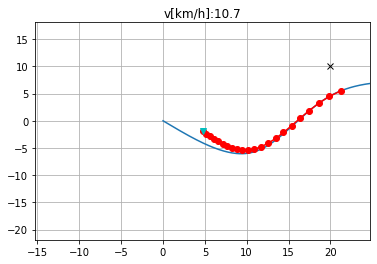

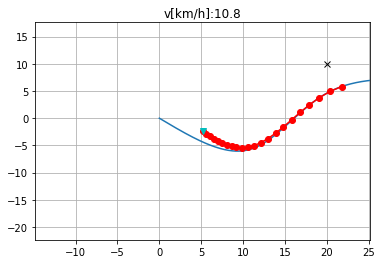

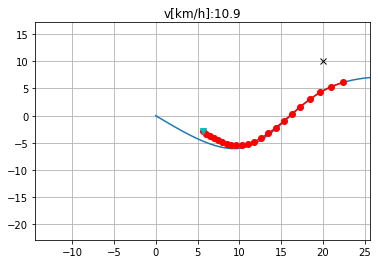

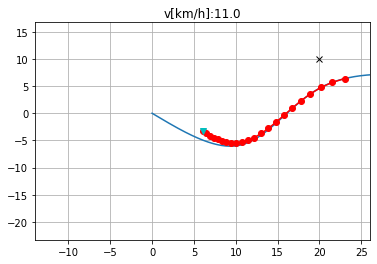

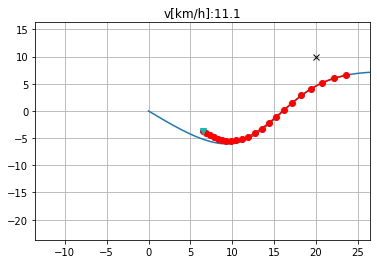

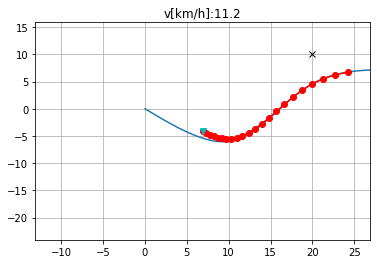

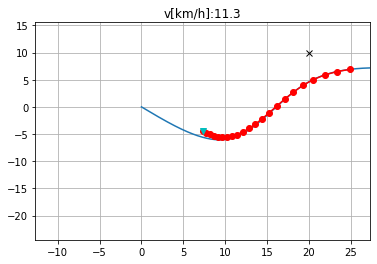

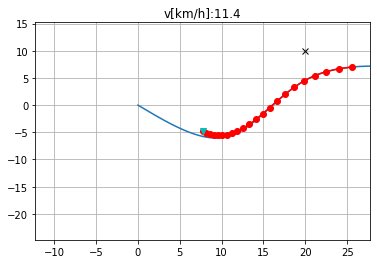

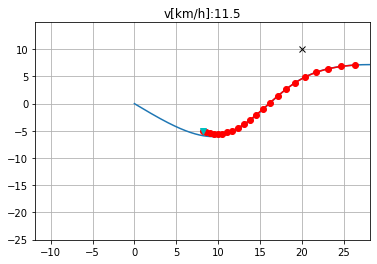

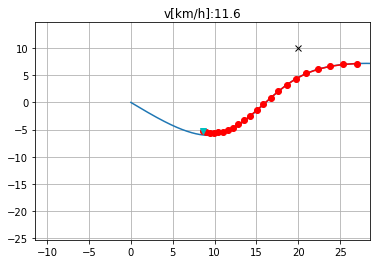

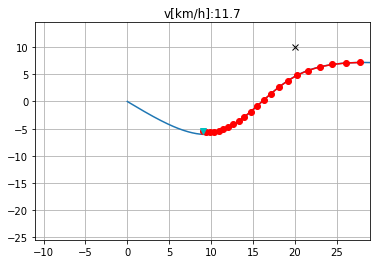

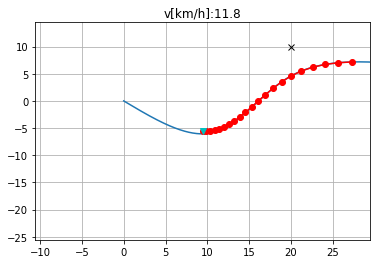

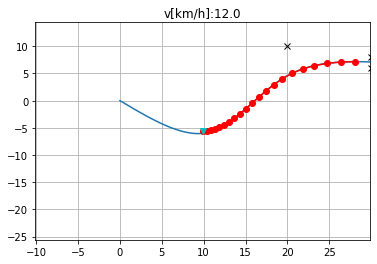

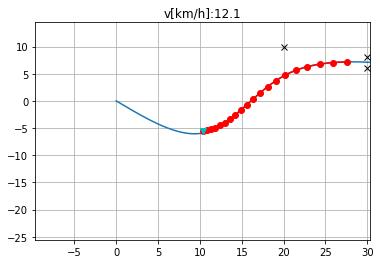

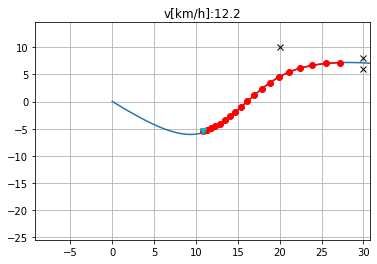

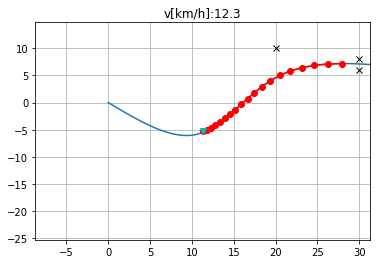

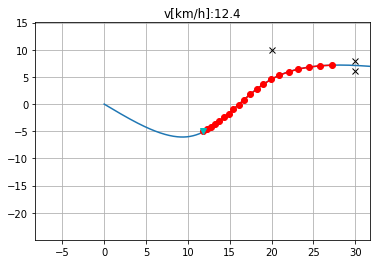

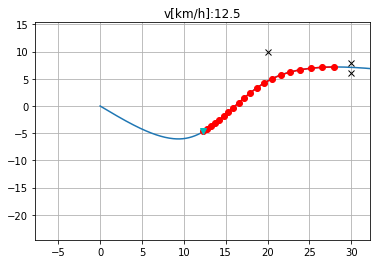

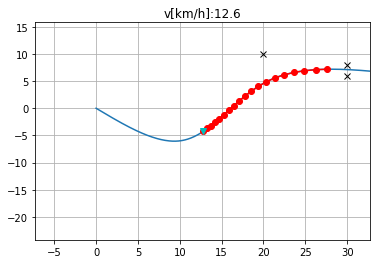

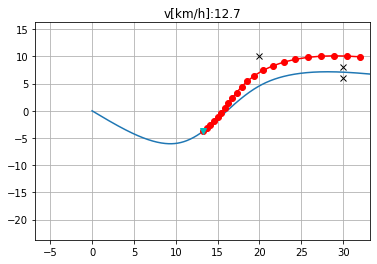

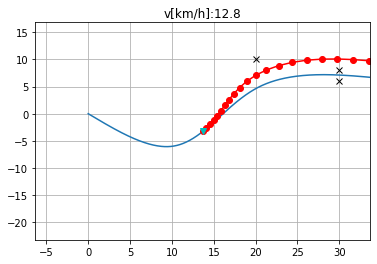

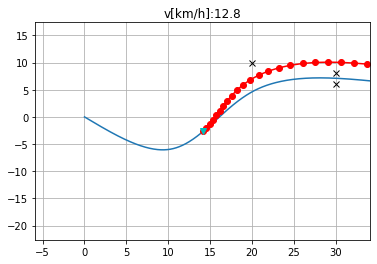

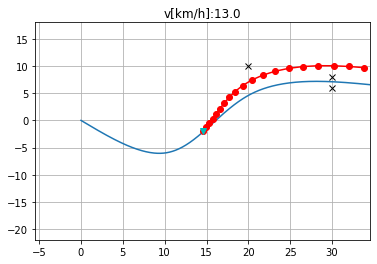

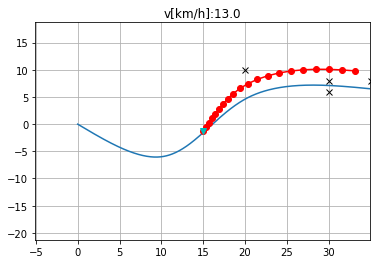

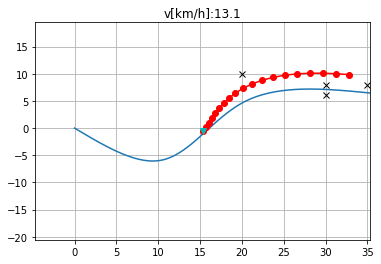

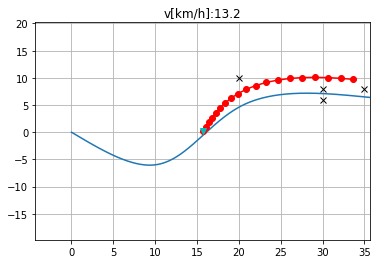

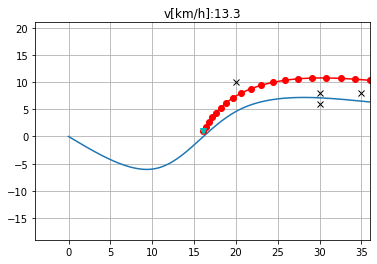

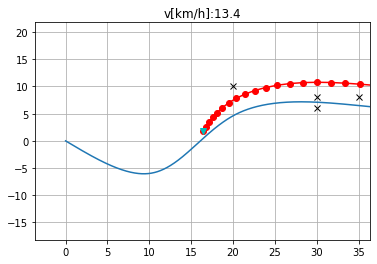

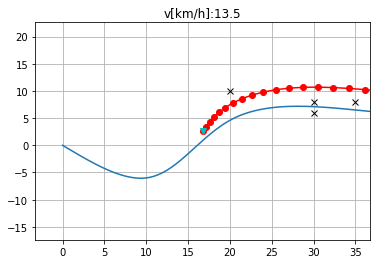

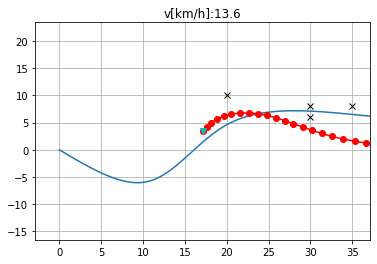

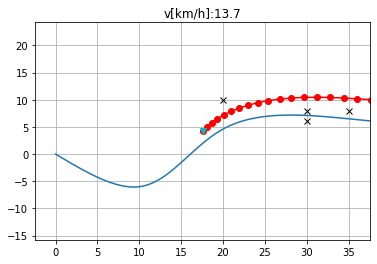

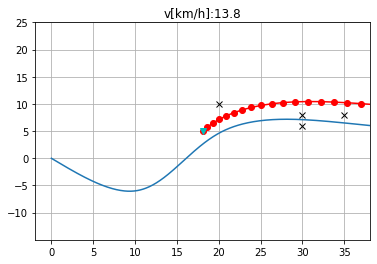

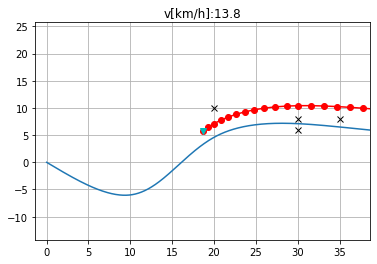

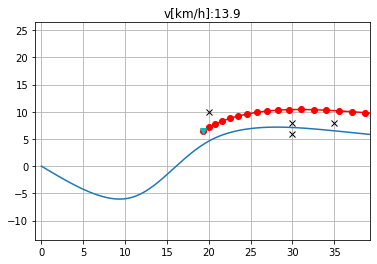

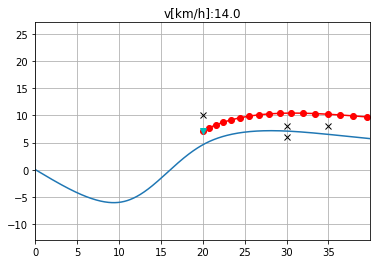

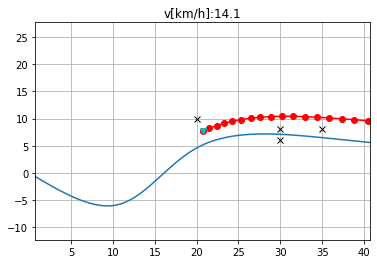

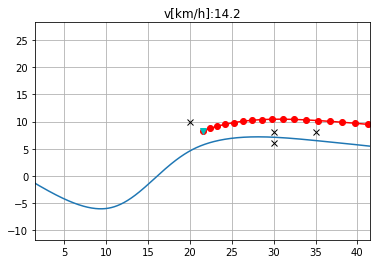

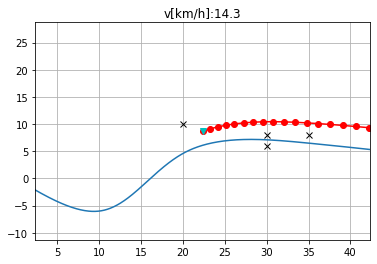

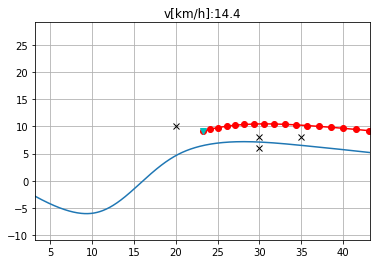

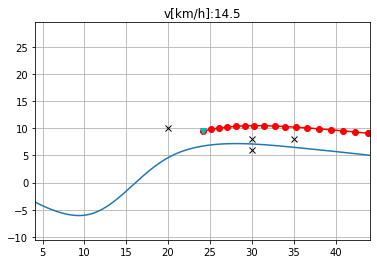

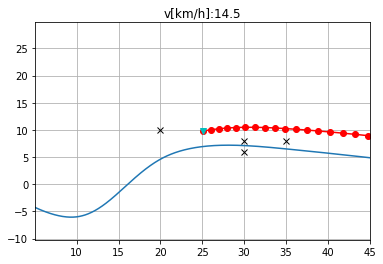

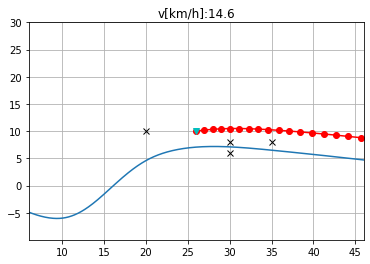

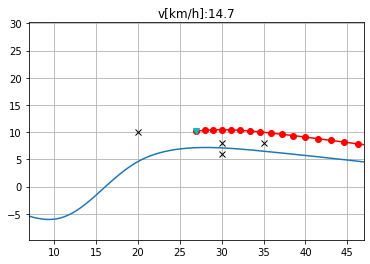

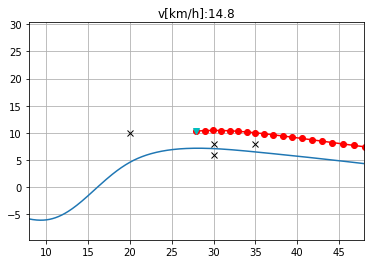

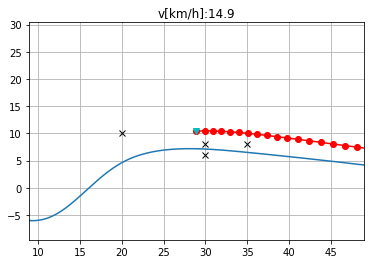

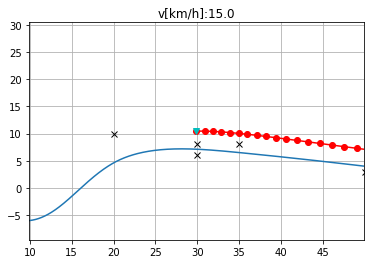

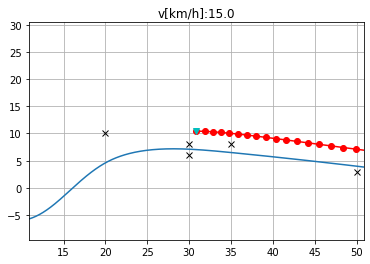

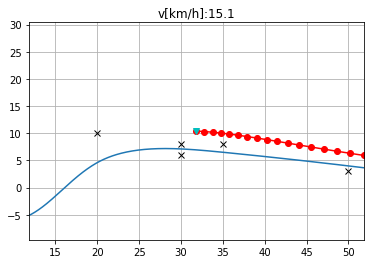

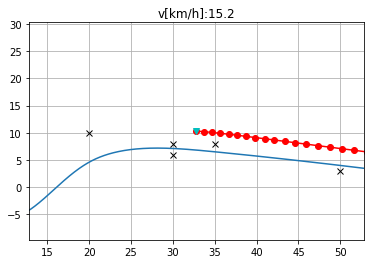

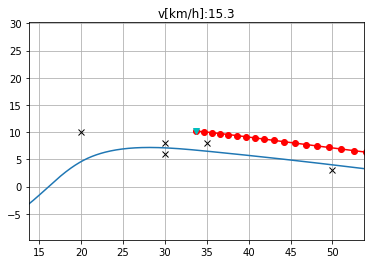

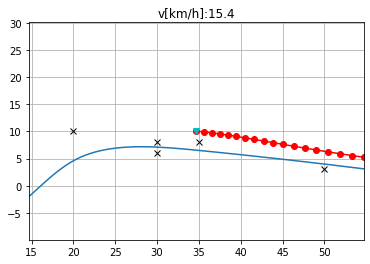

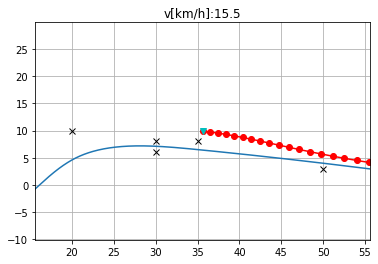

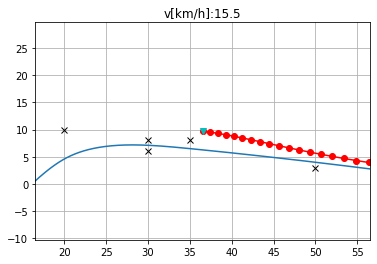

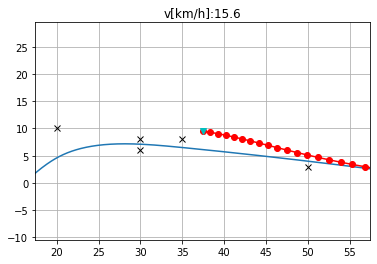

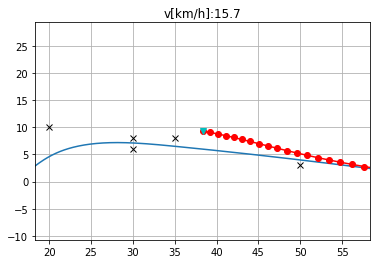

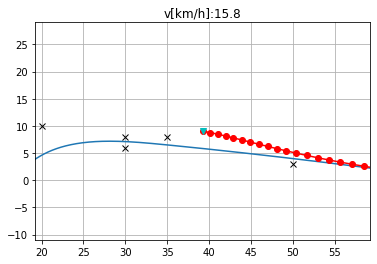

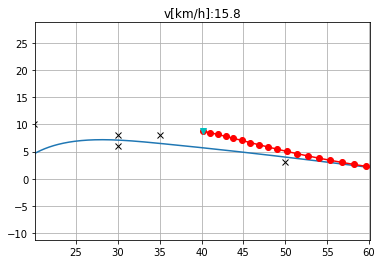

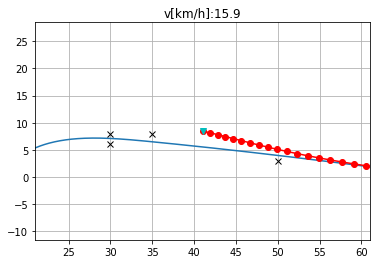

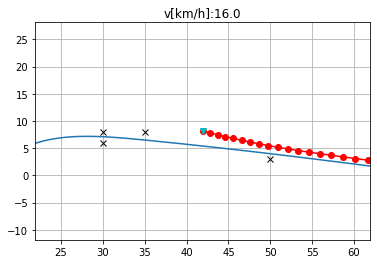

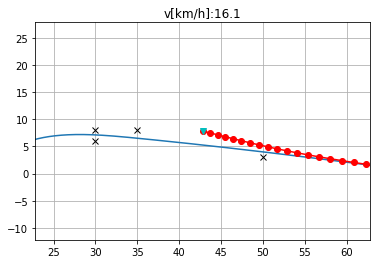

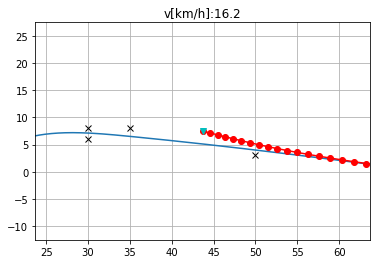

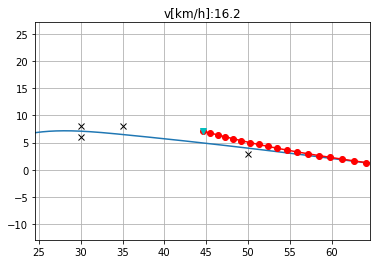

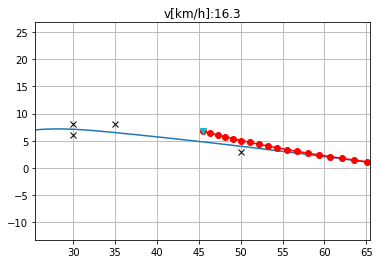

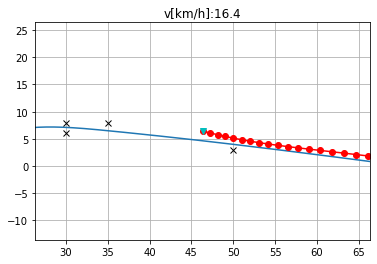

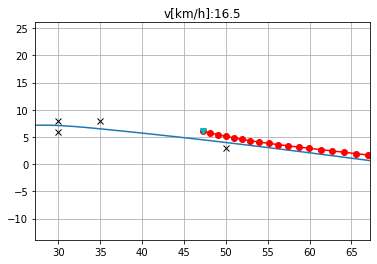

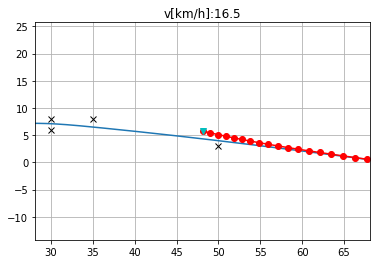

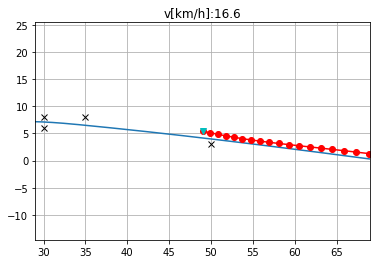

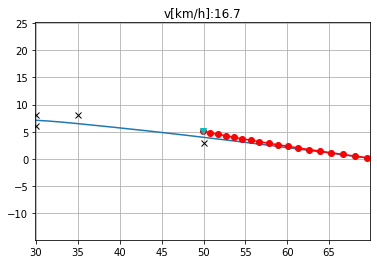

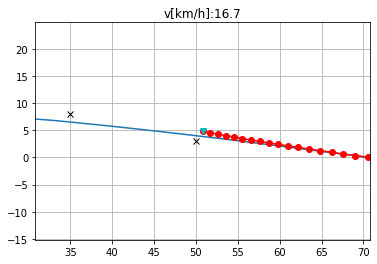

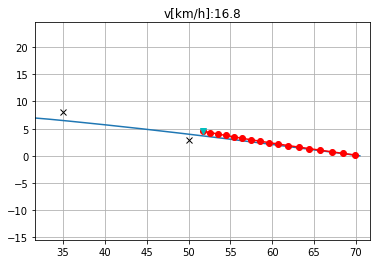

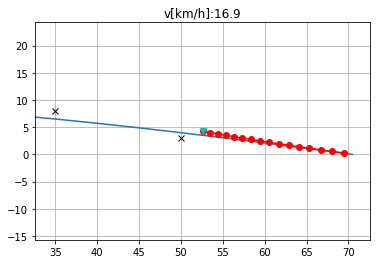

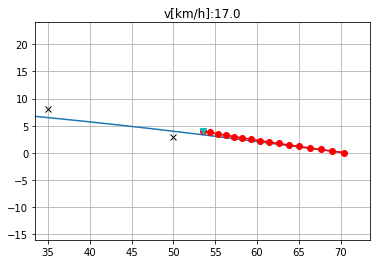

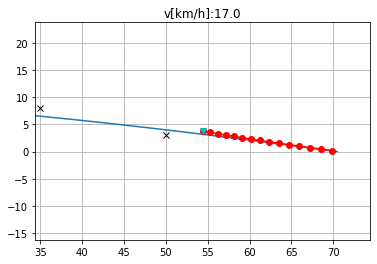

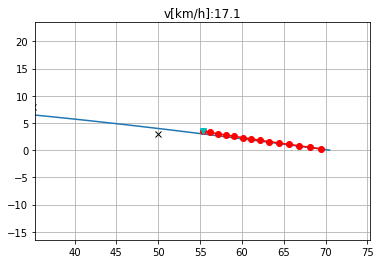

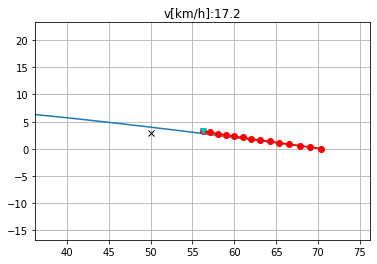

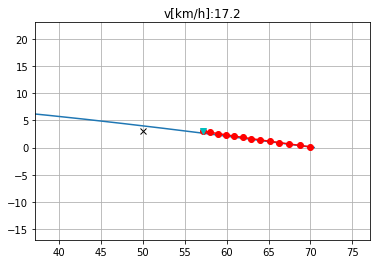

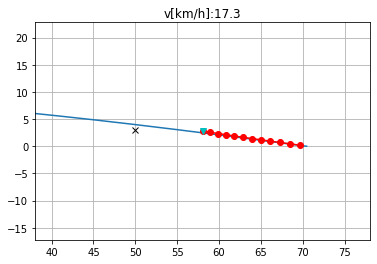

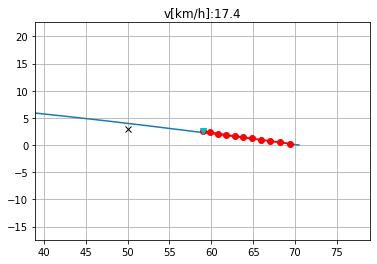

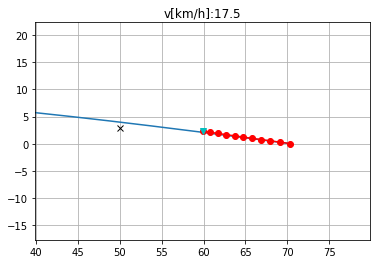

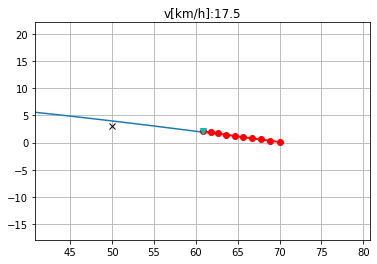

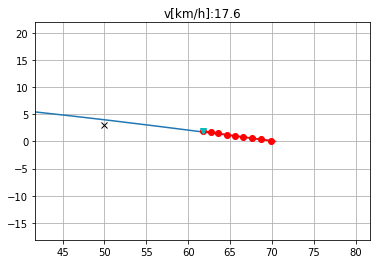

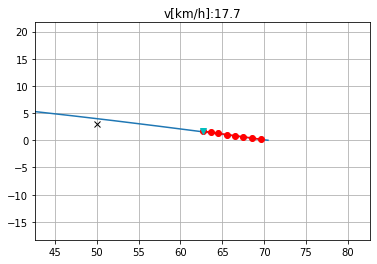

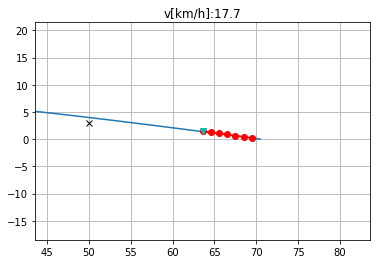

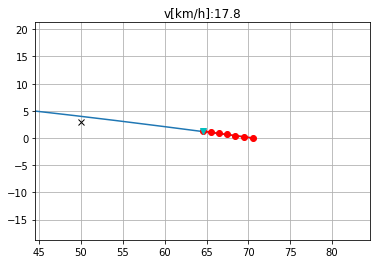

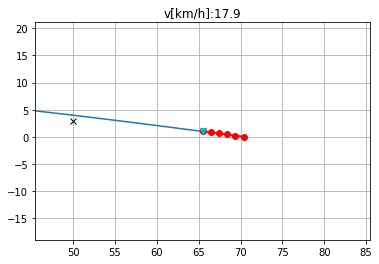

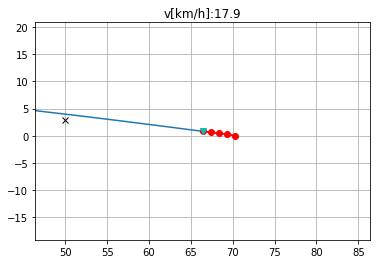

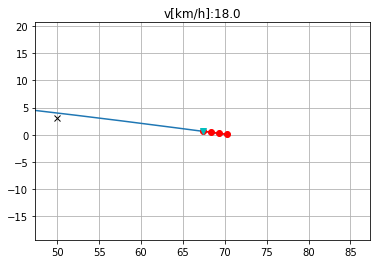

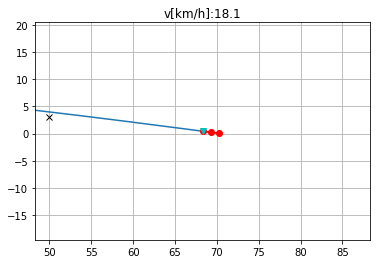

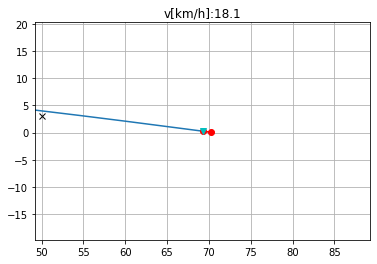

Goal
Finish


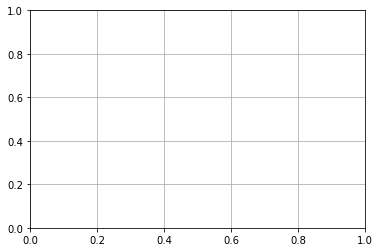

In [17]:
# way points
wx = [0.0, 10.0, 20.5, 35.0, 70.5]
wy = [0.0, -6.0, 5.0, 6.5, 0.0]
# obstacle lists
ob = np.array([[20.0, 10.0],
               [30.0, 6.0],
               [30.0, 8.0],
               [35.0, 8.0],
               [50.0, 3.0]
               ])

tx, ty, tyaw, tc, csp = generate_target_course(wx, wy)

# initial state
c_speed = 10.0 / 3.6  # current speed [m/s]
c_d = 2.0  # current lateral position [m]
c_d_d = 0.0  # current lateral speed [m/s]
c_d_dd = 0.0  # current latral acceleration [m/s]
s0 = 0.0  # current course position

area = 20.0  # animation area length [m]

for i in range(SIM_LOOP):
    path = frenet_optimal_planning(
        csp, s0, c_speed, c_d, c_d_d, c_d_dd, ob)

    s0 = path.s[1]
    c_d = path.d[1]
    c_d_d = path.d_d[1]
    c_d_dd = path.d_dd[1]
    c_speed = path.s_d[1]

    if np.hypot(path.x[1] - tx[-1], path.y[1] - ty[-1]) <= 1.0:
        print("Goal")
        break

    if show_animation:  # pragma: no cover
        plt.cla()
        plt.plot(tx, ty)
        plt.plot(ob[:, 0], ob[:, 1], "xk")
        plt.plot(path.x[1:], path.y[1:], "-or")
        plt.plot(path.x[1], path.y[1], "vc")
        plt.xlim(path.x[1] - area, path.x[1] + area)
        plt.ylim(path.y[1] - area, path.y[1] + area)
        plt.title("v[km/h]:" + str(c_speed * 3.6)[0:4])
        plt.grid(True)
        plt.pause(0.0001)

print("Finish")
if show_animation:  # pragma: no cover
    plt.grid(True)
    plt.pause(0.0001)
    plt.show()
        